# Xai _ Grad-Cam (TF)

In [69]:
import sys
sys.path.append('/Users/constance/Documents/Project_lung_cancer/src/Segmentation')
from TheDuneAI import ContourPilot as cp
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

# Imports for Xplique
import requests
from PIL import Image
BATCH_SIZE = 8
import torch
from torchvision.transforms.functional import to_pil_image, to_tensor, resize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import xplique


In [61]:
model_path = '/Users/constance/Documents/Project_lung_cancer/src/Segmentation/model_files/'
path_to_test_data = '/Users/constance/Documents/Project_lung_cancer/NIH dataset_raw/NRRD/converted_nrrds/'
save_path = '/Users/constance/Documents/Project_lung_cancer/NIH dataset_raw/Processed'

In [62]:
model = cp(model_path,path_to_test_data,save_path,verbosity=True)
for i, layer in enumerate(model.model1.layers):
        print(i, layer.name, layer.__class__.__name__)


100%|██████████| 299/299 [00:00<00:00, 5059.74it/s]

299  Patients found
Epoch end
------- Loading patients in predict mode -------
0 input_1 InputLayer
1 conv2d_1 Conv2D
2 conv2d_2 Conv2D
3 max_pooling2d_1 MaxPooling2D
4 conv2d_3 Conv2D
5 conv2d_4 Conv2D
6 max_pooling2d_2 MaxPooling2D
7 conv2d_5 Conv2D
8 conv2d_6 Conv2D
9 max_pooling2d_3 MaxPooling2D
10 conv2d_7 Conv2D
11 conv2d_8 Conv2D
12 dropout_1 Dropout
13 max_pooling2d_4 MaxPooling2D
14 conv2d_9 Conv2D
15 conv2d_10 Conv2D
16 dropout_2 Dropout
17 up_sampling2d_1 UpSampling2D
18 conv2d_11 Conv2D
19 concatenate_1 Concatenate
20 conv2d_12 Conv2D
21 conv2d_13 Conv2D
22 up_sampling2d_2 UpSampling2D
23 conv2d_14 Conv2D
24 concatenate_2 Concatenate
25 conv2d_15 Conv2D
26 conv2d_16 Conv2D
27 up_sampling2d_3 UpSampling2D
28 conv2d_17 Conv2D
29 concatenate_3 Concatenate
30 conv2d_18 Conv2D
31 conv2d_19 Conv2D
32 up_sampling2d_4 UpSampling2D
33 conv2d_20 Conv2D
34 concatenate_4 Concatenate
35 conv2d_21 Conv2D
36 conv2d_22 Conv2D
37 conv2d_23 Conv2D
38 conv2d_24 Conv2D


In [63]:
gen_with_progress = tqdm(model.Patients_gen, desc='Progress')
gen_iterator = iter(gen_with_progress)  # <-- transformer en itérateur
img, _, filename, params = next(gen_iterator)
print(img.shape) 

# Select the middle slice of the 3D image
print(f"Image shape: {img.shape}") 
img=img.squeeze()  
print(f"Image shape after squeeze: {img.shape}") 
# --- Select the middle slice ---
middle_index = img.shape[0] // 2
print(f"Middle slice index: {middle_index}")
middle_slice = img[middle_index, :, :]  # shape: (512, 512)

mask = model.model1.predict(img, batch_size=1, verbose=1)


Progress:   0%|          | 0/299 [01:24<?, ?it/s]


(44, 512, 512)
Window limits  -1000 150.0
Amount of unique values, original img:  1151 resampled img:  46
(1, 38, 512, 512)
Image shape: (1, 38, 512, 512)
Image shape after squeeze: (38, 512, 512)
Middle slice index: 19
38/38 [==============================] - 53s 1s/step


# Grad-cam (basic version)

In [64]:
def compute_gradcam(model, image, target_layer_name):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        # Use mean prediction over the output map for loss
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    return cam

def show_gradcam_overlay(image, cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    # Convert grayscale to BGR (3 channels)
    if len(image.shape) == 2:
        image_color = cv2.cvtColor(np.uint8(image * 255), cv2.COLOR_GRAY2BGR)
    else:
        image_color = np.uint8(image * 255)
    overlay = cv2.addWeighted(image_color, 1-alpha, heatmap, alpha, 0)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()


Middle slice shape: (512, 512)


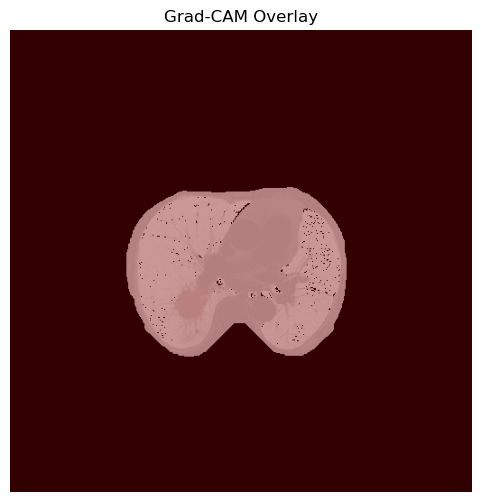

In [65]:
print(f"Middle slice shape: {middle_slice.shape}")
# --- Prepare the slice for the model ---
input_slice = middle_slice.reshape(512, 512, 1).astype(np.float32)

# --- Compute Grad-CAM ---
cam = compute_gradcam(model.model1, input_slice, target_layer_name="conv2d_23")

# --- Visualize overlay ---
show_gradcam_overlay(input_slice.squeeze(), cam)

# Xplique 

In [84]:
class ModelWrapper(torch.nn.Module):
    # WARNING: `torch.nn.Module` specific to pytorch
    # `tf.keras.Model` instead for tensorflow models

    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        #self.model = model.eval()
        self.model = model

    def __call__(self, torch_inputs):
        # this method should change depending on the model
        return torch.softmax(
            self.model(torch_inputs)["out"].permute([0, 2, 3, 1]),
            dim=-1)

    def to(self, device):
        # WARNING: specific to pytorch
        self.model.to(device)
        return self

    def zero_grad(self):
        # WARNING: specific to pytorch
        self.model.zero_grad()
        return self

segmentation_model = ModelWrapper(model.model1)

In [85]:
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad, SquareGrad,
                                  Occlusion, Rise, SobolAttributionMethod, HsicAttributionMethod)

from xplique.plots import plot_attributions

img_tf = tf.convert_to_tensor(img, dtype=tf.float32)
mask_tf = tf.convert_to_tensor(mask, dtype=tf.float32)

explainers = {
    Saliency: {},
    # GradientInput: {},
    # IntegratedGradients: {"steps": 20},
    # SmoothGrad: {"nb_samples": 50, "noise": 0.75},
    # VarGrad: {"nb_samples": 50, "noise": 0.75},
    # SquareGrad: {"nb_samples": 100, "noise": 0.5},
    Occlusion: {"patch_size": 40, "patch_stride": 10, "occlusion_value": 0},
    Rise: {"nb_samples": 4000, "grid_size": 13},
    # SobolAttributionMethod: {"nb_design": 32, "grid_size": 13},
    # HsicAttributionMethod: {"nb_design": 1500, "grid_size": 13}
}

explanations = {}
for explainer_class, params in explainers.items():
    torch.cuda.empty_cache()
    print(explainer_class.__name__)

    # instanciate explainer
    explainer = explainer_class(segmentation_model, operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
                                batch_size=1, **params)

    # compute explanations
    explanation = explainer(img, mask)

    # show explanations for a method
    plot_attributions(explanation, images_with_masks,
                      img_size=4., cols=images.shape[0],
                      cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)
    plt.show()

    # keep explanations in memory for metrics
    explanations[explainer_class.__name__] = explanation

Saliency


TypeError: in user code:

    File "/opt/anaconda3/envs/lung_env/lib/python3.10/site-packages/xplique/commons/operators_operations.py", line 168, in gradient  *
        scores = operator(model, inputs, targets)
    File "/opt/anaconda3/envs/lung_env/lib/python3.10/site-packages/xplique/commons/operators.py", line 93, in semantic_segmentation_operator  *
        scores = model(inputs) * targets
    File "/var/folders/dh/h5slh_zs525fbsjj29cgqmth0000gn/T/ipykernel_9377/492652786.py", line 14, in __call__  *
        dim=-1)

    TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'out'


In [ ]:
from xplique.metrics import Deletion, MuFidelity, Insertion, AverageStability
from xplique.plots.metrics import barplot

metrics = {}

# -------------------- MuFidelity's nb_samples was reduced for memory needs
# explanations metrics
explanations_metrics = {
    Deletion: {"baseline_mode": 0, "steps": 10, "max_percentage_perturbed": 0.5},
    MuFidelity: {"baseline_mode": 0, "nb_samples": 5, "subset_percent":0.2, "grid_size": 13},
    Insertion: {"baseline_mode": 0, "steps": 10, "max_percentage_perturbed": 0.5}
}
for metric_class, params in explanations_metrics.items():
    torch.cuda.empty_cache()
    # instanciate the metric
    metric = metric_class(wrapped_model, np.array(inputs[:3]), np.array(targets[:3]),
                          operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
                          activation="softmax", batch_size=BATCH_SIZE, **params)

    # iterate on methods explanations
    metrics[metric_class.__name__] = {}
    for method, explanation in explanations.items():
        metrics[metric_class.__name__][method] = metric(explanation[:3])

# # ----------------- Not included for computation cost reason
# # explainer metrics
# metric = AverageStability(wrapped_model, inputs[:3], targets[:3], batch_size=BATCH_SIZE,
#                           nb_samples=20, radius=0.1, distance="l2")
# metrics["AverageStability"] = {}
# for explainer_class, params in explainers.items():
#     torch.cuda.empty_cache()

#     # instanciate explainer
#     explainer = explainer_class(wrapped_model, operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
#                                 batch_size=BATCH_SIZE, **params)

#     metrics["AverageStability"][explainer_class.__name__] = metric.evaluate(explainer)

barplot(metrics, sort_metric="Deletion", ascending="True")
plt.show()